## Image Captioning

## Initialize the COCO API

In [2]:
import os
import sys
from pycocotools.coco import COCO

instances_annFile="E:\\Projects\\udacity_cv\\P2_image_caption\\instances_val2014.json"
coco = COCO(instances_annFile)

captions_annFile="E:\\Projects\\udacity_cv\\P2_image_caption\\captions_val2014.json"
coco_caps = COCO(captions_annFile)

ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=7.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.85s)
creating index...
index created!


## Plot a sample Image to visualize coco dataset

http://images.cocodataset.org/val2014/COCO_val2014_000000156076.jpg


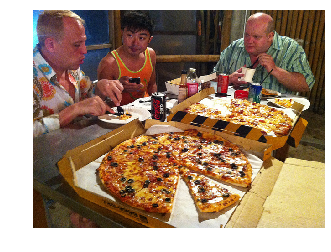

A couple of men and one young man eating pizza.
Guys sitting at a table eating pizza and talking 
three guys sitting at a table with two pizzas
Some people are seen eating several large pizzas.
The men are enjoying the very large pizzas.


In [3]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

## Data Loader 

In [9]:
import torch
import torch.nn as nn
from torchvision import transforms
import nltk
nltk.download('punkt')
from pycocotools.coco import COCO
from data_loader import get_loader
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

indices = data_loader.dataset.get_train_indices()
vocab_size = len(data_loader.dataset.vocab)

import torch.utils.data as data
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.06s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 414113/414113 [00:47<00:00, 8793.36it/s]


In [8]:
embed_size=512
batch_size = 512    
vocab_threshold = 5
vocab_from_file = True
hidden_size = 1024 

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]        
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)        
        self.bn1 = nn.BatchNorm1d(embed_size)        
        
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.linear(features)
        features = self.bn1(features)
        
        return features

encoder=EncoderCNN(embed_size)
encoder=encoder.to(device)
encoder

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, ker

In [4]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers=num_layers
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(hidden_size, vocab_size)        
        self.lstm = nn.LSTM(input_size=embed_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True, 
                            bidirectional=False)        
        
    def init_hidden(self, batch_size):        
        return torch.zeros(1, batch_size, self.hidden_size).to(device),torch.zeros(1, batch_size, self.hidden_size).to(device)

    def forward(self, features, captions):
        captions = captions[:, :-1]     
        self.batch_size = features.shape[0]
        self.hidden = self.init_hidden(self.batch_size)
        embeds = self.word_embeddings(captions)       
        inputs = torch.cat((features.unsqueeze(dim=1),embeds), dim=1)                      
        lstm_out, self.hidden = self.lstm(inputs,self.hidden)
        outputs=self.linear(lstm_out)       
        return outputs 

    def greedy_sample(self, inputs):        
        cap_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.linear(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            cap_output.append(max_indx.cpu().numpy()[0].item())             
            if (max_idx == 1):
                break
            
            inputs = self.word_embeddings(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return cap_output    
decoder=DecoderRNN(embed_size=512, hidden_size=1024 , vocab_size=8856, num_layers=1)
decoder=decoder.to(device)

decoder

DecoderRNN(
  (word_embeddings): Embedding(8856, 512)
  (linear): Linear(in_features=1024, out_features=8856, bias=True)
  (lstm): LSTM(512, 1024, batch_first=True)
)

In [5]:
import math

num_epochs = 15           
save_every = 1             
print_every = 100         
log_file = 'training_log.txt'       

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn1.parameters())

learning_rate=0.006
optimizer = torch.optim.Adam(params,lr=learning_rate)
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

In [6]:
import torch.utils.data as data
import numpy as np
import os
import sys

f = open(log_file, 'w')
for epoch in range(1, num_epochs+1):    
    for i_step in range(1, total_step+1):        
        indices = data_loader.dataset.get_train_indices()        
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        images, captions = next(iter(data_loader))
        images = images.to(device)
        captions = captions.to(device)
        decoder.zero_grad()
        encoder.zero_grad()
        features = encoder(images)
        features=features.to(device)
        outputs = decoder(features, captions)
        outputs=outputs.to(device)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        loss.backward()
        optimizer.step()
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        print('\r' + stats, end="")
        sys.stdout.flush()
        f.write(stats + '\n')
        f.flush()
        if i_step % print_every == 0:
            print('\r' + stats)
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

f.close()

Epoch [5/10], Step [100/809], Loss: 2.0390, Perplexity: 7.6831
Epoch [5/10], Step [200/809], Loss: 2.6062, Perplexity: 13.5481
Epoch [5/10], Step [300/809], Loss: 1.7999, Perplexity: 6.04939
Epoch [5/10], Step [400/809], Loss: 1.9095, Perplexity: 6.74970
Epoch [5/10], Step [500/809], Loss: 1.9132, Perplexity: 6.77458
Epoch [5/10], Step [600/809], Loss: 2.2175, Perplexity: 9.184762
Epoch [5/10], Step [700/809], Loss: 1.7885, Perplexity: 5.98064
Epoch [5/10], Step [800/809], Loss: 2.0573, Perplexity: 7.82481
Epoch [6/10], Step [100/809], Loss: 1.8098, Perplexity: 6.1090
Epoch [6/10], Step [200/809], Loss: 1.7771, Perplexity: 5.9126
Epoch [6/10], Step [300/809], Loss: 1.7033, Perplexity: 5.49211
Epoch [6/10], Step [400/809], Loss: 1.8910, Perplexity: 6.62583
Epoch [6/10], Step [500/809], Loss: 1.7910, Perplexity: 5.99530
Epoch [6/10], Step [600/809], Loss: 2.1290, Perplexity: 8.40611
Epoch [6/10], Step [700/809], Loss: 2.0172, Perplexity: 7.51736
Epoch [6/10], Step [800/809], Loss: 1.8184

KeyboardInterrupt: 

## Get Data Loader for Test Dataset

In [1]:
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.RandomCrop(224),                     
    transforms.RandomHorizontalFlip(),              
    transforms.ToTensor(),                          
    transforms.Normalize((0.485, 0.456, 0.406),     
                         (0.229, 0.224, 0.225))])

data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


## Generate Predictions

In [ ]:
encoder.eval()
decoder.eval()

def clean_sentence(output):
    sentence = ''
    for x in output[1:]:
        if x == 1:
            break
        sentence += ' ' + data_loader.dataset.vocab.idx2word[x]
    return sentence

def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.greedy_sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

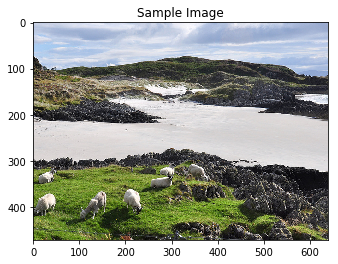

 a flock of sheep are grazing in the grass .


In [8]:
get_prediction()

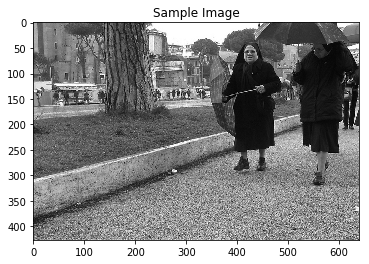

 a woman walking down a street carrying an umbrella .


In [10]:
get_prediction()

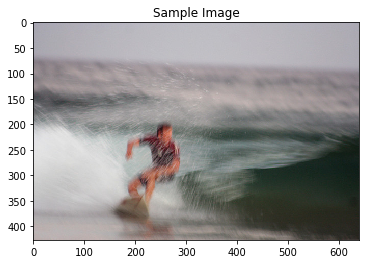

 a man is surfing on a big wave


In [14]:
get_prediction()